<a href="https://colab.research.google.com/github/ZZongSeung/ALEXNET-algorithm/blob/main/VGGNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image

In [2]:
train = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
# 데이터 생성

train_img = datasets.MNIST(
    root = "/content",
    transform = ToTensor(),
    train=True,
    download=True
)

test_img = datasets.MNIST(
    root = "/content",
    transform = ToTensor(),
    train=False,
    download=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4293528.27it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 125415.63it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1178001.72it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3071179.88it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [17]:
# 데이터 생성

train_img1 = datasets.MNIST(
    root = "/content",
    transform = ToTensor(),
    train=True,
    download=True
)

test_img1 = datasets.MNIST(
    root = "/content",
    transform = ToTensor(),
    train=False,
    download=True
)

In [5]:
# 데이터 확인
data, target = next(iter(train_img))

print(data.shape) # RGB = 1(흑백 데이터 유추)
print(target)

torch.Size([1, 28, 28])
5


In [18]:
# 데이터 Loader에 생성 - batch = 128
train_loader = DataLoader(train_img1, batch_size=128, shuffle=True)
test_loader = DataLoader(test_img1, batch_size=128, shuffle=True)

In [7]:
# 이미지 확인 - MNIST는 정규화가 안된다. 범위가 [0,1] 사이이므로
img, target = next(iter(train_img))
print(target)

5


In [19]:
target1 = target
list_name = [target1[i].item() for i in range(len(target1))] # item은 0차원 array에서만 생성이 가능하다.

# dict type 생성
target_name = {}

for i in range(len(list_name)):
  target_name[f"{i}"] = i

TypeError: object of type 'int' has no len()

In [20]:
# 데이터 그림
#
np.random.seed(1234)
def loop_graph(row, col, data):
    fig, axs = plt.subplots(row, col, figsize=(10, 10))

    for i in range(row):
        for j in range(col):
            index = i * col + j
            if index < row * col:
                # 무작위로 인덱스 선택
                indice = np.random.randint(len(data))
                img, target = data[indice]

                axs[i, j].imshow(img.squeeze(), cmap='gray')
                axs[i, j].set_title(f"Label: {target}")
                axs[i, j].axis('off')
            else:
                fig.delaxes(axs[i, j])  # 필요하지 않은 축 제거

    plt.tight_layout()
    plt.show()

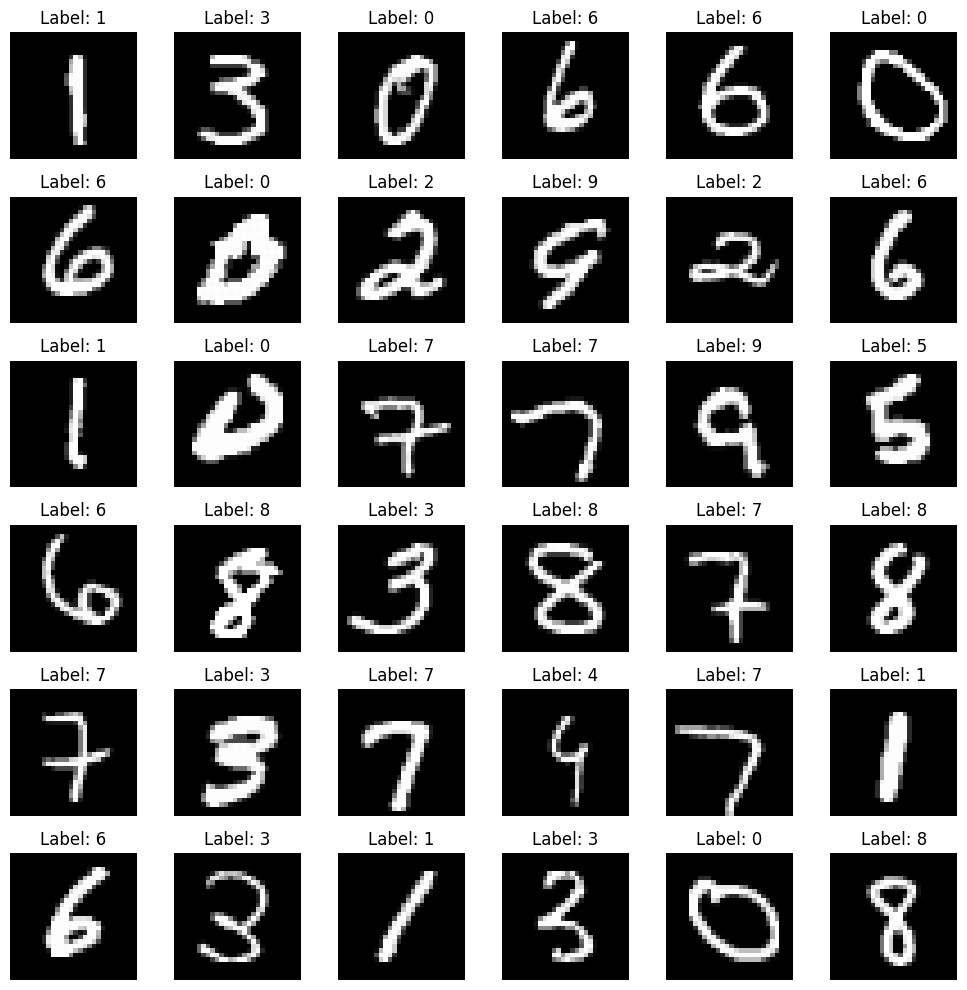

In [21]:
loop_graph(6, 6, train_img1)

# model 생성

## 문제 정의
----
- VGGNet 구조 살펴보기



![VGG](https://miro.medium.com/max/1100/0*6VP81rFoLWp10FcG)

In [22]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGGNet(nn.Module):
    def __init__(self, vgg_name):
        super(VGGNet, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512*1*1, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
      layers = []
      n_channels = 1  # 입력 채널 수, MNIST에서는 1 (흑백 이미지)

      for x in cfg:
        if x == "M":
            layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)]
        else:
            layers += [nn.Conv2d(n_channels, x, kernel_size=3, padding=1),
                       nn.BatchNorm2d(x),
                       nn.ReLU(inplace=True)]
            n_channels = x
      return nn.Sequential(*layers)

In [24]:
# cuda 설정
if torch.cuda.is_available()==True:
  device = torch.device("cuda")
  print(device)
else:
  device = torch.device("cpu")
  print(device)

cuda


In [35]:
model = VGGNet('VGG13').to(device)
from torch.optim import Adam

# set hyper parameter
lr = 1e-4
loss = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = lr)

In [112]:
# train_loop
def train_loop(train_loader, model, loss_fn, optimizer):
  model.train()
  size = len(train_loader.dataset)

  for batch, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    # 모델에 넣은 예측값 생성
    pred = model(data)

    # 손실 정의
    loss = loss_fn(pred, target)

    # 역전파
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0: # 여기서 batch는 루프가 돌아가는 횟수임
      loss, current = loss.item(), batch * len(data)
      print(f'loss: {loss:>7f}  [{current:>5d}]/{size:5d}')

In [37]:
epochs = 10
best_correct = 0.0  # 가장 높은 정확도를 저장할 변수
best_epoch = 0      # 가장 높은 정확도를 가진 에포크 번호를 저장할 변수

# 최적 epochs일 때 예측값을 넣기
best_real = []
best_predict = []
error = {}

for i in range(epochs):  # 에포크 횟수
    print(f"Epoch {i+1} \n------------------------")
    train_loop(train_loader, model, loss, optimizer)

    # test_loop 임--------------------------------------------.
    set_size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss = 0
    correct = 0

    current_real = []
    current_predict = []

    with torch.no_grad():
        for batch, (input, target) in enumerate(test_loader):
            input, target = input.to(device), target.to(device)
            pred = model(input)

            test_loss += loss(pred, target).item()  # 각 배치 손실 더하기
            correct += (pred.argmax(1) == target).type(torch.float).sum().item()  # 정확한 예측 수 더하기

            # 현재 배치의 예측 값과 실제 값을 저장
            current_predict.extend(pred.argmax(1).cpu().numpy())
            current_real.extend(target.cpu().numpy())

    test_loss /= num_batches  # 에포크 전체에 대한 평균 손실
    correct /= set_size       # 에포크 전체에 대한 정확도
    error[i]=test_loss   # 에포크 별 에러 저장
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:8f}\n")

    # 정확도에 따른 best epoch 업데이트
    if correct > best_correct:
        best_correct = correct
        best_epoch = i + 1
        best_predict = current_predict  # 최적 에포크의 예측 값 저장
        best_real = current_real        # 최적 에포크의 실제 값 저장

print(f"Best epoch is {best_epoch} with an accuracy of {best_correct*100:.1f}%")

Epoch 1 
------------------------
loss: 2.309545  [    0]/60000
loss: 0.041537  [12800]/60000
loss: 0.048008  [25600]/60000
loss: 0.065078  [38400]/60000
loss: 0.027804  [51200]/60000
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.051297

Epoch 2 
------------------------
loss: 0.035886  [    0]/60000
loss: 0.012986  [12800]/60000
loss: 0.011440  [25600]/60000
loss: 0.010072  [38400]/60000
loss: 0.020092  [51200]/60000
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.037369

Epoch 3 
------------------------
loss: 0.033284  [    0]/60000
loss: 0.021169  [12800]/60000
loss: 0.007207  [25600]/60000
loss: 0.003156  [38400]/60000
loss: 0.114944  [51200]/60000
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.031792

Epoch 4 
------------------------
loss: 0.011948  [    0]/60000
loss: 0.034499  [12800]/60000
loss: 0.005697  [25600]/60000
loss: 0.009648  [38400]/60000
loss: 0.008185  [51200]/60000
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.031891

Epoch 5 
------------------------
loss: 0.030874  [    0]/60